<a href="https://colab.research.google.com/github/jpbeccaria/Other-proyects/blob/main/Classification_Models_for_a_Cardiotocogram_Dataset_(with_pipelines!).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gdown
import pandas as pd
from scipy.io import arff
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
import pyproj
from shapely.geometry import Point
from geopy.distance import geodesic
import re
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPatch
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import pickle

# Descripción del Conjunto de Datos - Cardiotocograms (CTGs)

**Autores**: J. P. Marques de Sá, J. Bernardes, D. Ayers de Campos.

**Fuente**: UCI

**Cita**: Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318, UCI

Este conjunto de datos contiene información sobre 2126 cardiotocogramas (CTGs) fetales que fueron procesados automáticamente, y se midieron las características diagnósticas respectivas. Los CTGs también fueron clasificados por tres obstetras expertos y se asignó una etiqueta de clasificación de consenso a cada uno de ellos. La clasificación se realizó tanto con respecto a un patrón morfológico (A, B, C, ...) como a un estado fetal (N, S, P). Por lo tanto, el conjunto de datos se puede utilizar tanto para experimentos de 10 clases como de 3 clases.

## Información de Atributos:

1. **LB** - Línea de base de la frecuencia cardíaca fetal (latidos por minuto).
2. **AC** - Número de aceleraciones por segundo.
3. **FM** - Número de movimientos fetales por segundo.
4. **UC** - Número de contracciones uterinas por segundo.
5. **DL** - Número de deceleraciones leves por segundo.
6. **DS** - Número de deceleraciones severas por segundo.
7. **DP** - Número de deceleraciones prolongadas por segundo.
8. **ASTV** - Porcentaje de tiempo con variabilidad a corto plazo anormal.
9. **MSTV** - Valor medio de la variabilidad a corto plazo.
10. **ALTV** - Porcentaje de tiempo con variabilidad a largo plazo anormal.
11. **MLTV** - Valor medio de la variabilidad a largo plazo.
12. **Width** - Ancho del histograma de la frecuencia cardíaca fetal.
13. **Min** - Mínimo del histograma de la frecuencia cardíaca fetal.
14. **Max** - Máximo del histograma de la frecuencia cardíaca fetal.
15. **Nmax** - Número de picos en el histograma.
16. **Nzeros** - Número de ceros en el histograma.
17. **Mode** - Moda del histograma.
18. **Mean** - Media del histograma.
19. **Median** - Mediana del histograma.
20. **Variance** - Varianza del histograma.
21. **Tendency** - Tendencia del histograma.
22. **NSP** - Código de clase del estado fetal (N=normal; S=sospechoso; P=patológico).


In [ ]:
csv_url = "https://drive.usercontent.google.com/download?id=1exLP9Am91lToe10eF12Ri4zmGI0w8JxB&export=download&authuser=0&confirm=t&uuid=0a87faf2-c07f-476f-8c8f-095a431dc0eb&at=APZUnTWnLt5qopfEmpSjsygfsBP8:1693686852074"

output = "/content/cardiotocography.csv"

gdown.download(csv_url, output, quiet=False)

data = pd.read_csv(output, sep="\t")
data.head(3)

Downloading...
From: https://drive.usercontent.google.com/download?id=1exLP9Am91lToe10eF12Ri4zmGI0w8JxB&export=download&authuser=0&confirm=t&uuid=0a87faf2-c07f-476f-8c8f-095a431dc0eb&at=APZUnTWnLt5qopfEmpSjsygfsBP8:1693686852074
To: /content/cardiotocography.csv
100%|██████████| 284k/284k [00:00<00:00, 88.2MB/s]


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240,357,120,120,0,0,0,...,0,0,0,0,0,0,1,0,9,2
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5,632,132,132,4,0,4,...,0,0,0,1,0,0,0,0,6,1
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177,779,133,133,2,0,5,...,0,0,0,1,0,0,0,0,6,1




> Eliminamos columnas que no nos interesan



In [ ]:
droped_columns = ['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE']
data = data[['LB','AC','FM','UC','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency', 'NSP']]




> Agrupamos la clase 1 (normal) = 0 y clase 2,3 (sospechoso, patológico) = 1 para que nos queden dos clases



In [ ]:
data['NSP'] = data['NSP'].replace({1:0, 2:1, 3:1})
data.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0,0,0,0,0,0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,1
1,132,4,0,4,2,0,0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,0
2,133,2,0,5,2,0,0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,0
3,134,2,0,6,2,0,0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,0
4,132,4,0,5,0,0,0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,0




> ## Estadistica descriptiva



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   int64  
 2   FM        2126 non-null   int64  
 3   UC        2126 non-null   int64  
 4   DL        2126 non-null   int64  
 5   DS        2126 non-null   int64  
 6   DP        2126 non-null   int64  
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

In [ ]:
data.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,2.722484,7.241298,3.659925,1.570085,0.003293,0.126058,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,0.221543
std,9.840844,3.560850,37.125309,2.847094,2.499229,0.057300,0.464361,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.415383
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,0.000000
25%,126.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,0.000000
50%,133.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,0.000000
75%,140.000000,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,0.000000
max,160.000000,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,1.000000




> Vemos porcentaje de nulos para nuestro dataset



In [ ]:
null_percentage = (data.isnull().sum() / len(data)) * 100

print(null_percentage)

LB          0.0
AC          0.0
FM          0.0
UC          0.0
DL          0.0
DS          0.0
DP          0.0
ASTV        0.0
MSTV        0.0
ALTV        0.0
MLTV        0.0
Width       0.0
Min         0.0
Max         0.0
Nmax        0.0
Nzeros      0.0
Mode        0.0
Mean        0.0
Median      0.0
Variance    0.0
Tendency    0.0
NSP         0.0
dtype: float64


In [ ]:
for column in data.columns:
    unique_count = data[column].nunique()
    print(f"{column}: {unique_count}")

LB: 48
AC: 22
FM: 96
UC: 19
DL: 15
DS: 2
DP: 5
ASTV: 75
MSTV: 57
ALTV: 87
MLTV: 249
Width: 154
Min: 109
Max: 86
Nmax: 18
Nzeros: 9
Mode: 88
Mean: 103
Median: 95
Variance: 133
Tendency: 3
NSP: 2


In [ ]:
numeric_features = ['LB', 'AC', 'FM', 'UC', 'DL', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Mode', 'Mean', 'Median', 'Variance']
categorical_features = ['DS', 'DP', 'Nzeros', 'Tendency']



> Vemos la proporcion de las clases de nuestro target



In [ ]:
pd.value_counts(data['NSP'], sort = True, normalize=True)


0    0.778457
1    0.221543
Name: NSP, dtype: float64

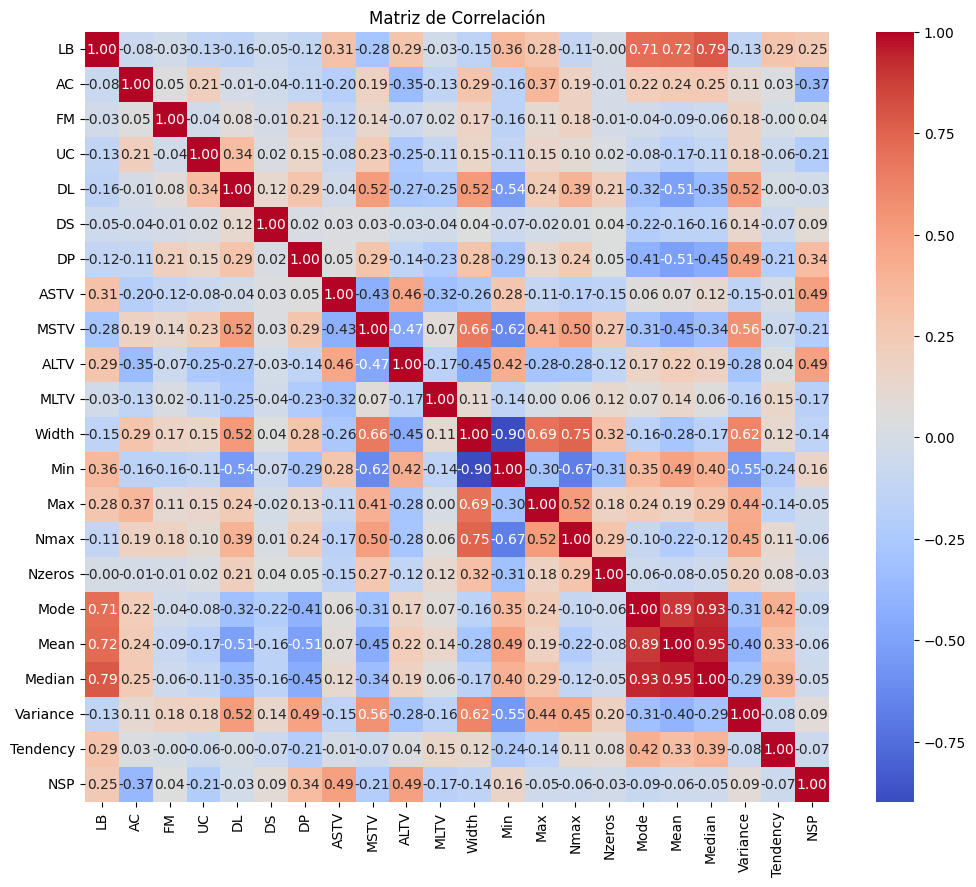

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# lo comento porque tarda mucho
# sns.pairplot(data[numeric_features + ['NSP']], hue='NSP')

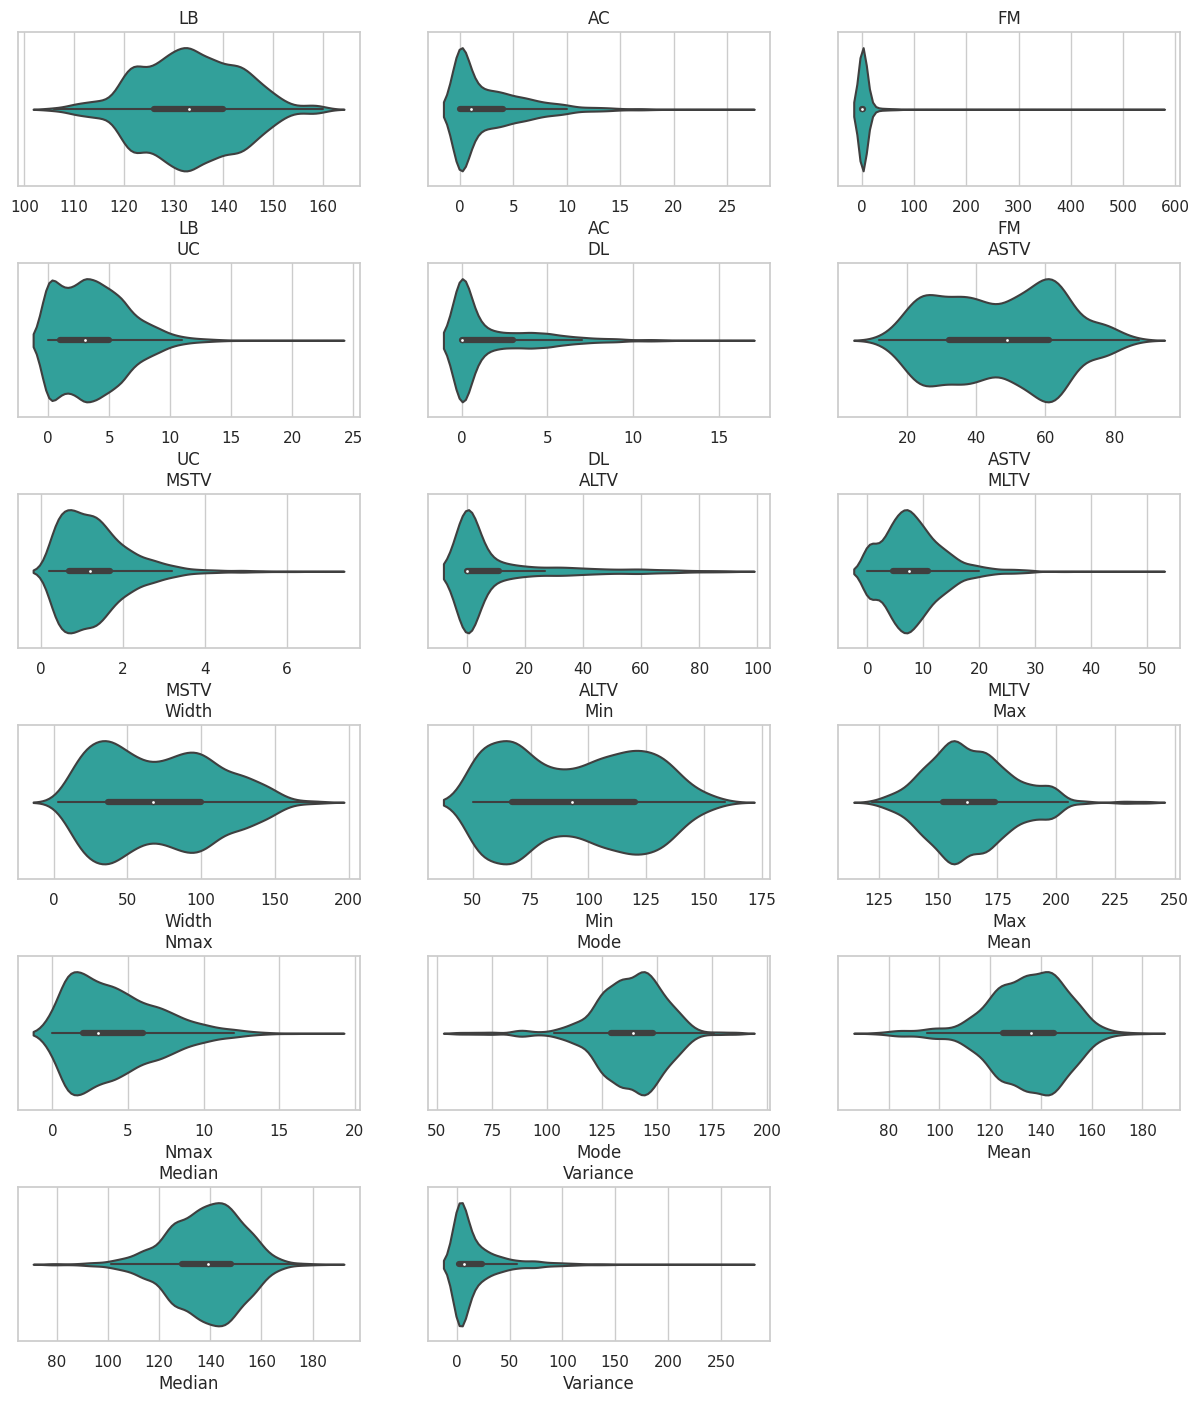

In [ ]:
sns.set(style="whitegrid")

num_rows, num_cols = 7, 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(data[numeric_features].columns):
    row, col_index = divmod(i, num_cols)

    sns.violinplot(x=data[numeric_features][col], ax=axes[row, col_index], color = "lightseagreen")
    axes[row, col_index].set_title(col)

for i in range(len(data[numeric_features].columns), num_rows * num_cols):
    fig.delaxes(axes[divmod(i, num_cols)])

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


X = data.drop("NSP", axis=1)
y = data["NSP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1488, 21), (638, 21), (1488,), (638,))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve

 # Crear listas para cada métrica
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_roc_list = []

def eval_model(model, X_test, y_test, average='weighted'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred, average=average), 2)
    recall = round(recall_score(y_test, y_pred, average=average), 2)
    f1 = round(f1_score(y_test, y_pred, average=average), 2)

    auc_roc = roc_auc_score(y_test, y_proba)

    cm = confusion_matrix(y_test, y_pred)

    results = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }

    print("Resultados de la evaluación:")
    for metric, value in results.items():
        print(f"{metric}: {value}")

    # Agregar los valores a las listas globales
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_roc_list.append(auc_roc)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Matriz de Confusión")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'AUC-ROC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    return results, fpr, tpr



> ## XGBoost

Mejores hiperparámetros encontrados:
{'classifier__class_weight': None, 'classifier__learning_rate': 0.55, 'classifier__max_depth': 4, 'classifier__n_estimators': 39, 'preprocessor__num': MinMaxScaler(), 'selector__k': 22}
Puntaje del conjunto de hiperparámetros seleccionados: 0.8600
Resultados de la evaluación:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
AUC-ROC: 0.9822523852794185


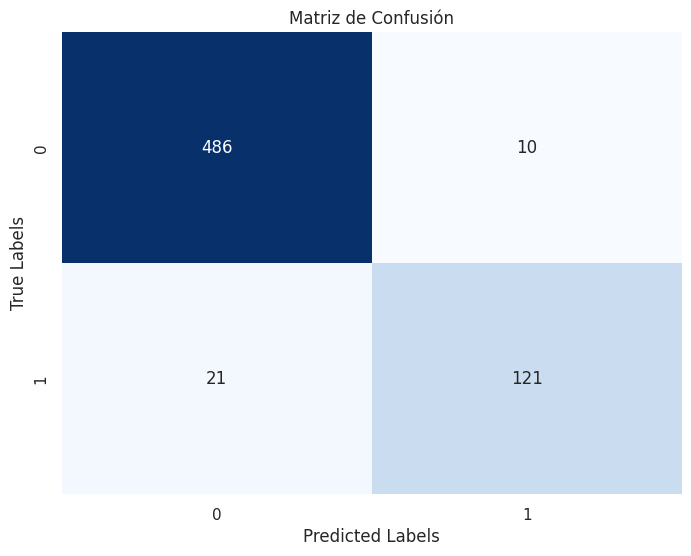

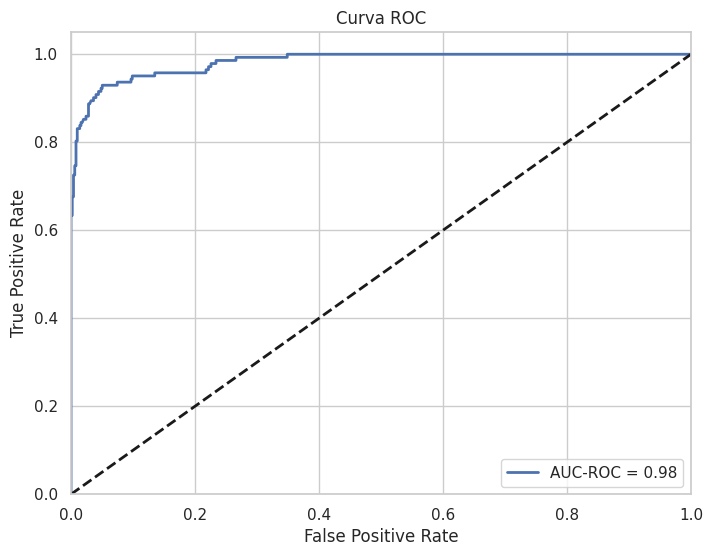

({'Accuracy': 0.95,
  'Precision': 0.95,
  'Recall': 0.95,
  'F1 Score': 0.95,
  'AUC-ROC': 0.9822523852794185},
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00201613, 0.00201613,
        0.00403226, 0.00403226, 0.00604839, 0.00604839, 0.00806452,
        0.00806452, 0.01008065, 0.01008065, 0.0141129 , 0.0141129 ,
        0.01612903, 0.01612903, 0.01814516, 0.02016129, 0.02419355,
        0.02419355, 0.02822581, 0.02822581, 0.03024194, 0.03225806,
        0.03629032, 0.03629032, 0.04032258, 0.04032258, 0.04435484,
        0.04435484, 0.0483871 , 0.0483871 , 0.05040323, 0.05040323,
        0.07459677, 0.07459677, 0.08669355, 0.09072581, 0.09677419,
        0.09677419, 0.09879032, 0.09879032, 0.13508065, 0.13508065,
        0.18145161, 0.18548387, 0.21774194, 0.21774194, 0.22177419,
        0.22177419, 0.22580645, 0.22580645, 0.23387097, 0.23387097,
   

In [ ]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif,RFECV,RFE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector',SelectKBest(f_classif)),
    ('classifier', XGBClassifier())
])

# dejo los mejores hyper parametros encontrados
param_grid = {
    'preprocessor__num': [MinMaxScaler()],  # [StandardScaler(), MinMaxScaler(), None],
    'selector__k': np.arange(5, 30, 1),
    'classifier__n_estimators': [39],  # np.arange(20,45,5),
    'classifier__max_depth': [4],  # np.arange(2,7,1),
    'classifier__learning_rate': [0.55],  # np.arange(0.45, 0.75, 0.01)
    'classifier__class_weight': [None, 'balanced']
}

grid_search_xgboost = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)

grid_search_xgboost.fit(X_train, y_train)
best_score = grid_search_xgboost.best_score_
print("Mejores hiperparámetros encontrados:")
print(grid_search_xgboost.best_params_)
print(f"Puntaje del conjunto de hiperparámetros seleccionados: {best_score:.4f}")
eval_model(grid_search_xgboost, X_test, y_test)



> Grafico como varia el score en relación a la cantidad de features seleccionadas




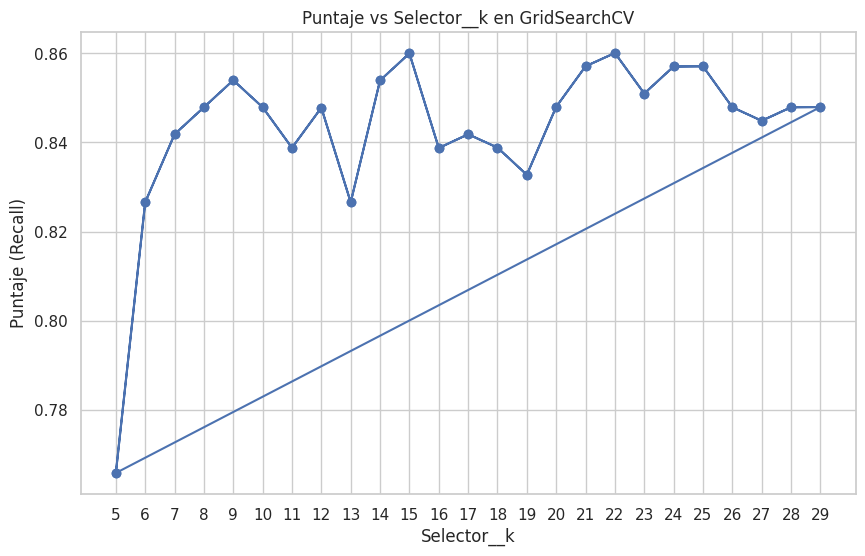

In [ ]:
import matplotlib.pyplot as plt

results = grid_search_xgboost.cv_results_

k_values = results['param_selector__k']
mean_test_scores = results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_test_scores, marker='o', linestyle='-')
plt.title('Puntaje vs Selector__k en GridSearchCV')
plt.xlabel('Selector__k')
plt.ylabel('Puntaje (Recall)')
plt.xticks(range(min(k_values), max(k_values)+1))

plt.grid(True)
plt.show()

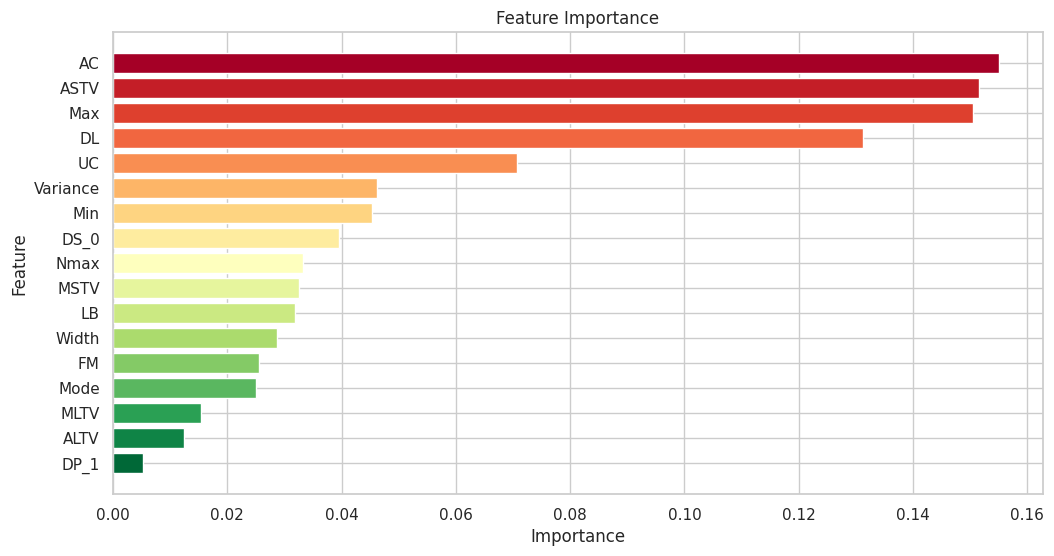

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

model = grid_search_xgboost.best_estimator_

# obtengo features importances
importances = model.named_steps['classifier'].feature_importances_

# mapeo las caracteristicas tanto numericas y categoricas
column_transformer = grid_search_xgboost.best_estimator_.named_steps['preprocessor']
categorical_transformer = column_transformer.named_transformers_['cat']
categorical_feature_names = categorical_features
onehot_encoder = categorical_transformer.named_steps['onehot']
onehot_encoder.fit(X_train[categorical_feature_names])
encoded_category_names = onehot_encoder.get_feature_names_out(input_features=categorical_feature_names)
all_feature_names = list(numeric_features) + list(encoded_category_names)

# filtramos y ordenamos por las features mayores a 0, luego del filtro de la feature seleccion
important_feature_names = [feature_name for importance, feature_name in sorted(zip(importances, all_feature_names), reverse=True) if importance > 0]
important_importances = [importance for importance, feature_name in sorted(zip(importances, all_feature_names), reverse=True) if importance > 0]

# grafico de barras lateral
plt.figure(figsize=(12, 6))
# degrade de rojo a verde
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(important_feature_names)))
plt.barh(important_feature_names, important_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

Refrescamos que significaba cada una.

-1 ASTV - Porcentaje de tiempo con variabilidad a corto plazo anormal

-2 AC - Número de aceleraciones por segundo

-3 DL - Número de deceleraciones leves por segundo

-4 Nmax - Número de picos en el histograma

-5 DP - Número de deceleraciones prolongadas por segundo.

-6 UC - Número de contracciones uterinas por segundo.

-7 Mode - Moda del histograma.


<Figure size 10000x8000 with 0 Axes>

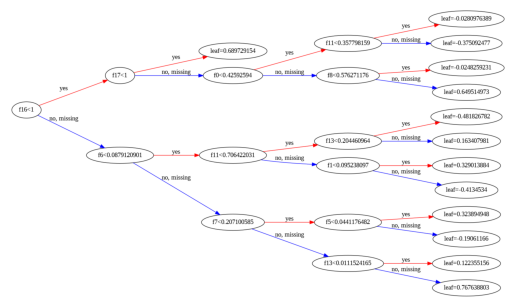

In [ ]:
from xgboost import plot_tree

best_xgb_model = grid_search_xgboost.best_estimator_.named_steps['classifier']

plt.figure(figsize=(100, 80))
plot_tree(best_xgb_model, num_trees=5, rankdir='LR')
# la imagen se ve muy mal pero se guarda en el directorio con mejor resolución
plt.savefig('arbol_xgboost.png', dpi=300)
plt.show()


> ## Bagging con DecisionTreeClassifier



In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier()

bagging_model = BaggingClassifier(base_classifier, n_estimators=100, random_state=0)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif)),
    ('classifier', bagging_model)
])

param_grid = {
    'preprocessor__num': [MinMaxScaler()],  # [StandardScaler(), MinMaxScaler(), None],
    'selector__k': [12],  # np.arange(10,20,1),
    'classifier__n_estimators': [82],  # np.arange(80,100,1),
    'classifier__base_estimator__max_depth': [4]  # np.arange(2,5,1)
}

grid_search_bagging = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_bagging.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search_bagging.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:236: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  valid_params[key].set_params(**sub_params)


Mejores hiperparámetros encontrados:
{'classifier__base_estimator__max_depth': 4, 'classifier__n_estimators': 82, 'preprocessor__num': MinMaxScaler(), 'selector__k': 12}


Resultados de la evaluación:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.93
AUC-ROC: 0.9559788164470696


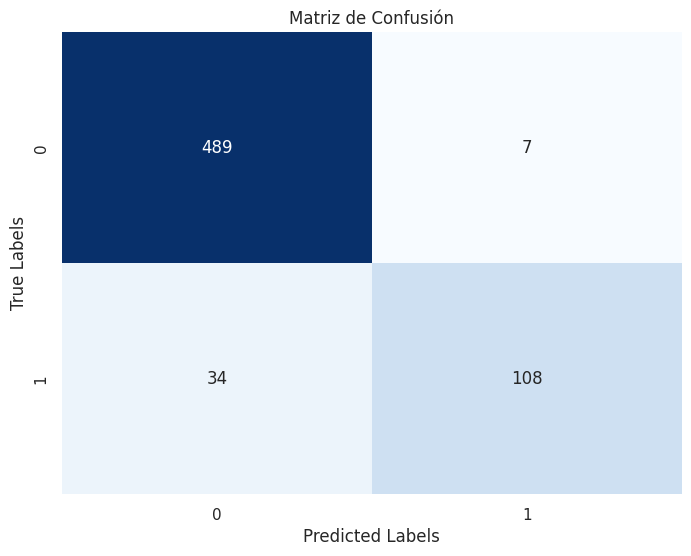

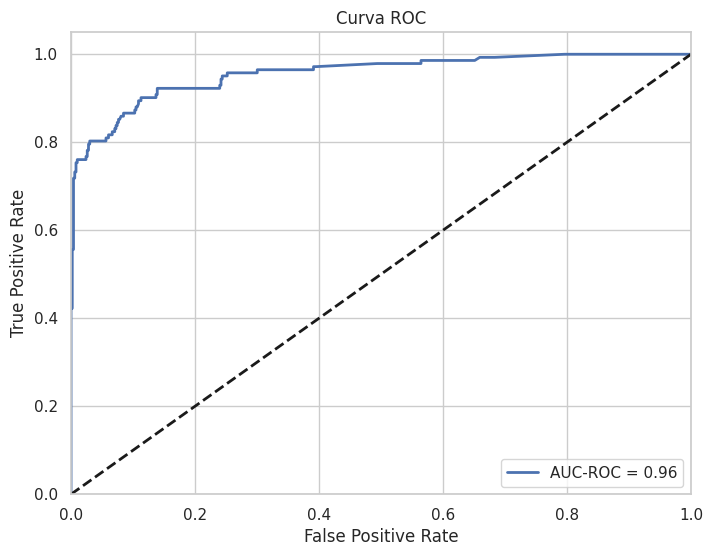

({'Accuracy': 0.94,
  'Precision': 0.94,
  'Recall': 0.94,
  'F1 Score': 0.93,
  'AUC-ROC': 0.9559788164470696},
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00201613, 0.00201613,
        0.00201613, 0.00201613, 0.00201613, 0.00201613, 0.00201613,
        0.00201613, 0.00201613, 0.00403226, 0.00403226, 0.00604839,
        0.00604839, 0.00806452, 0.00806452, 0.01008065, 0.01008065,
        0.02419355, 0.02419355, 0.02620968, 0.02620968, 0.02822581,
        0.02822581, 0.03024194, 0.03024194, 0.03427419, 0.03830645,
        0.04032258, 0.04435484, 0.05040323, 0.05443548, 0.05645161,
        0.05645161, 0.06048387, 0.06048387, 0.06653226, 0.06653226,
        0.07056452, 0.07056452, 0.07258065, 0.07258065, 0.07459677,
        0.07459677, 0.0766129 , 0.0766129 , 0.07862903, 0.08064516,
        0.08467742, 0.08467742, 0.10282258, 0.10282258, 0.10483871,
   

In [ ]:
eval_model(grid_search_bagging, X_test, y_test)

## ExtraTrees 😖


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [37], #np.arange(20, 50, 1),
    'max_depth': [9], #np.arange(2, 10, 1),
    'min_samples_split': [8], #np.arange(1, 10, 1),
    'random_state': [42]
}

et_classifier = ExtraTreesClassifier()
grid_search = GridSearchCV(et_classifier, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.fit(X_train, y_train))

best_params = grid_search.best_params_
best_et_classifier = grid_search.best_estimator_


print("Mejores hiperparámetros encontrados:")
print(best_params)


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [9], 'min_samples_split': [8],
                         'n_estimators': [37], 'random_state': [42]},
             scoring='recall')
Mejores hiperparámetros encontrados:
{'max_depth': 9, 'min_samples_split': 8, 'n_estimators': 37, 'random_state': 42}


In [ ]:
et = ExtraTreesClassifier(n_estimators=10000, class_weight='balanced', random_state=1)

In [ ]:
et.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', n_estimators=10000,
                     random_state=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
confusion_matrix(y_test, et.predict(X_test))

array([[484,  12],
       [ 22, 120]])

In [ ]:
accuracy_score(y_test, et.predict(X_test))

0.9467084639498433

Resultados de la evaluación:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
AUC-ROC: 0.9869519536574284


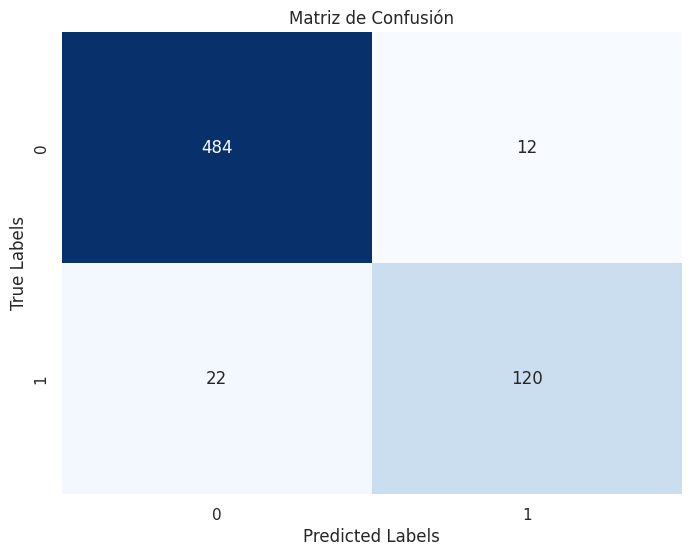

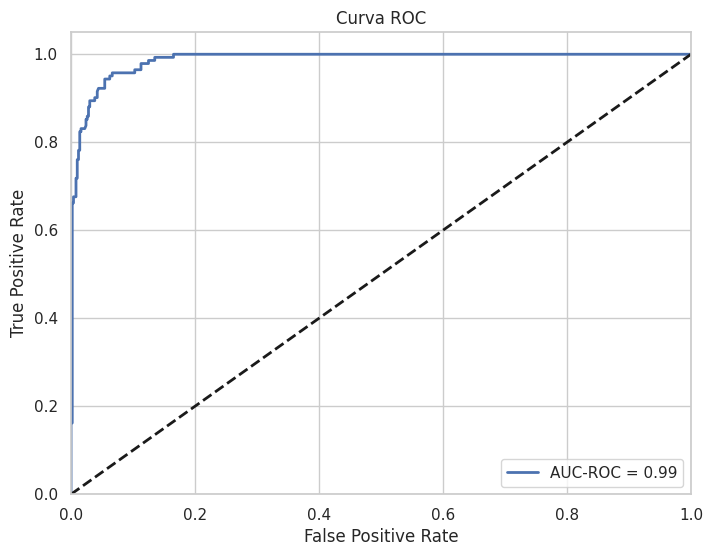

({'Accuracy': 0.95,
  'Precision': 0.95,
  'Recall': 0.95,
  'F1 Score': 0.95,
  'AUC-ROC': 0.9869519536574284},
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00201613, 0.00201613, 0.00201613, 0.00201613, 0.00403226,
        0.00403226, 0.00806452, 0.00806452, 0.01008065, 0.01008065,
        0.01209677, 0.01209677, 0.0141129 , 0.0141129 , 0.01612903,
        0.01612903, 0.02217742, 0.02419355, 0.02419355, 0.02620968,
        0.02620968, 0.02822581, 0.02822581, 0.03024194, 0.03024194,
        0.03830645, 0.03830645, 0.04233871, 0.04233871, 0.04435484,
        0.05443548, 0.05443548, 0.0625    , 0.0625    , 0.06653226,
        0.06653226, 0.10282258, 0.10282258, 0.11290323, 0.11290323,
        0.125     , 0.125     , 0.13508065, 0.13508065, 0.16532258,
        0.16532258, 0.20766129, 0.21169355, 0.24193548, 0.24596774,
        0.28629032, 0.29032258, 0.30846774, 0.3125    , 0.34274194,
        0.35080645, 0.35282258, 0.3608871 , 0.39919355, 0.40322581,
   

In [ ]:
eval_model(et, X_test, y_test)

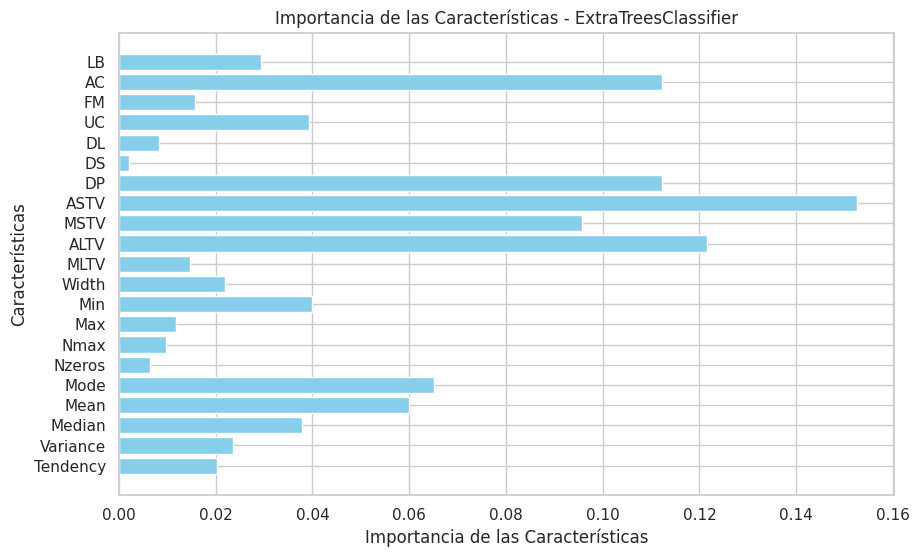

In [ ]:
import matplotlib.pyplot as plt

feature_importances = best_et_classifier.feature_importances_

feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Importancia de las Características')
plt.ylabel('Características')
plt.title('Importancia de las Características - ExtraTreesClassifier')
plt.gca().invert_yaxis()
plt.show()



## Bagging con Random Forest Classifier (pesadisimo)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

base_classifier = RandomForestClassifier()

bagging_model = BaggingClassifier(base_classifier, n_estimators=100, random_state=0)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif)),
    ('classifier', bagging_model)
])

param_grid = {
    'preprocessor__num': [MinMaxScaler()], # [StandardScaler(), MinMaxScaler(), None],
    'selector__k': [15], # np.arange(10,20,1),
    'classifier__n_estimators': [82],  # np.arange(80,100,1),
    'classifier__base_estimator__max_depth': [4]  # np.arange(2,5,1)
}

grid_search_bagging = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search_bagging.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search_bagging.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:236: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  valid_params[key].set_params(**sub_params)


Mejores hiperparámetros encontrados:
{'classifier__base_estimator__max_depth': 4, 'classifier__n_estimators': 82, 'preprocessor__num': MinMaxScaler(), 'selector__k': 15}


Resultados de la evaluación:
Accuracy: 0.92
Precision: 0.91
Recall: 0.92
F1 Score: 0.91
AUC-ROC: 0.9593224670604271


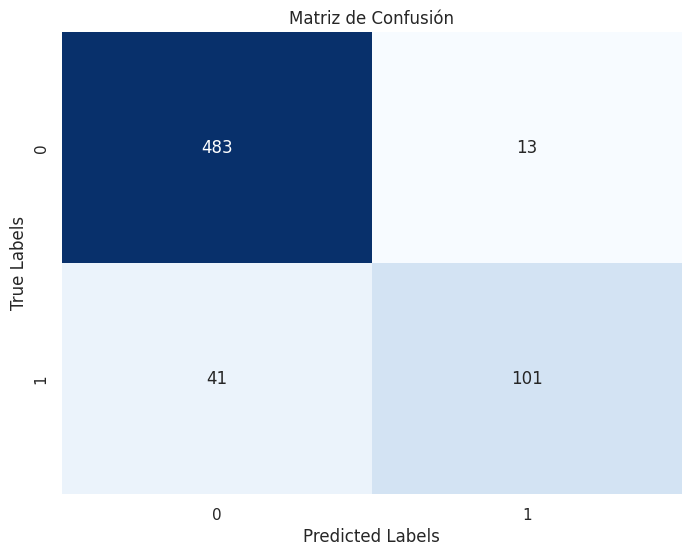

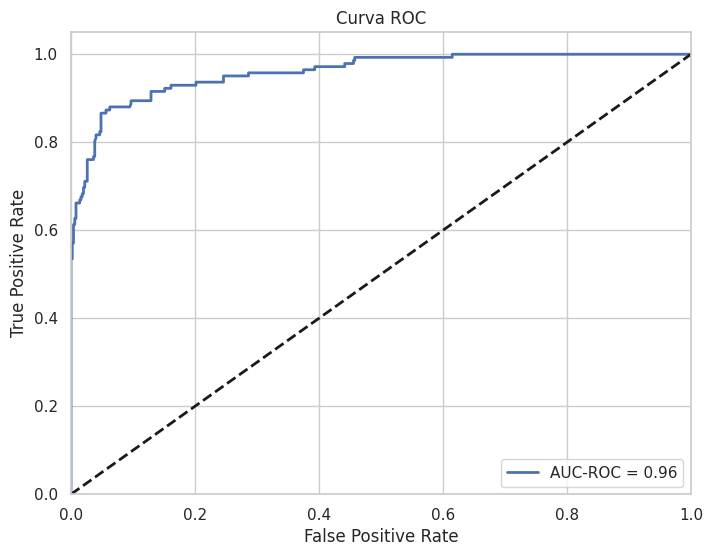

({'Accuracy': 0.92,
  'Precision': 0.91,
  'Recall': 0.92,
  'F1 Score': 0.91,
  'AUC-ROC': 0.9593224670604271},
 array([0.        , 0.        , 0.        , 0.00201613, 0.00201613,
        0.00403226, 0.00403226, 0.00604839, 0.00604839, 0.00806452,
        0.00806452, 0.0141129 , 0.0141129 , 0.01612903, 0.01612903,
        0.01814516, 0.01814516, 0.02016129, 0.02016129, 0.02217742,
        0.02217742, 0.02620968, 0.02620968, 0.03629032, 0.03629032,
        0.03830645, 0.03830645, 0.04032258, 0.04032258, 0.04637097,
        0.04637097, 0.0483871 , 0.0483871 , 0.05645161, 0.05645161,
        0.0625    , 0.0625    , 0.09475806, 0.09677419, 0.09677419,
        0.12903226, 0.12903226, 0.15120968, 0.15120968, 0.16129032,
        0.16129032, 0.2016129 , 0.2016129 , 0.24596774, 0.24596774,
        0.28629032, 0.28629032, 0.375     , 0.375     , 0.39314516,
        0.39314516, 0.41935484, 0.4233871 , 0.44153226, 0.44153226,
        0.45564516, 0.45564516, 0.45766129, 0.45766129, 0.61491935,
   

In [ ]:
eval_model(grid_search_bagging, X_test, y_test)

## Balanceando el dataset

Si bien estuvimos trabajando con un dataset algo desbalanceado, la diferencia entre las clases target se encuentran dentro del mismo orden de magnitud y las métricas de performance resultan sorprendentemente buenas. Sin embargo nos parece interesante evaluar si, balanceando el dataset los resultados mejoran.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# Entrenar y evaluar modelo con oversampling
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=1)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)


# Entrenar y evaluar modelo con subsampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=1)
X_train_subsampled, y_train_subsampled = undersampler.fit_resample(X_train, y_train)

In [ ]:
# Verificamos que efectivamente quedaron balanceados
y_train_oversampled.value_counts()

0    1159
1    1159
Name: NSP, dtype: int64

In [ ]:
y_train_subsampled.value_counts()

0    329
1    329
Name: NSP, dtype: int64

Mejores hiperparámetros encontrados:
{'classifier__class_weight': None, 'classifier__learning_rate': 0.55, 'classifier__max_depth': 4, 'classifier__n_estimators': 39, 'preprocessor__num': MinMaxScaler(), 'selector__k': 22}
Puntaje del conjunto de hiperparámetros seleccionados: 0.8600
Resultados de la evaluación:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0


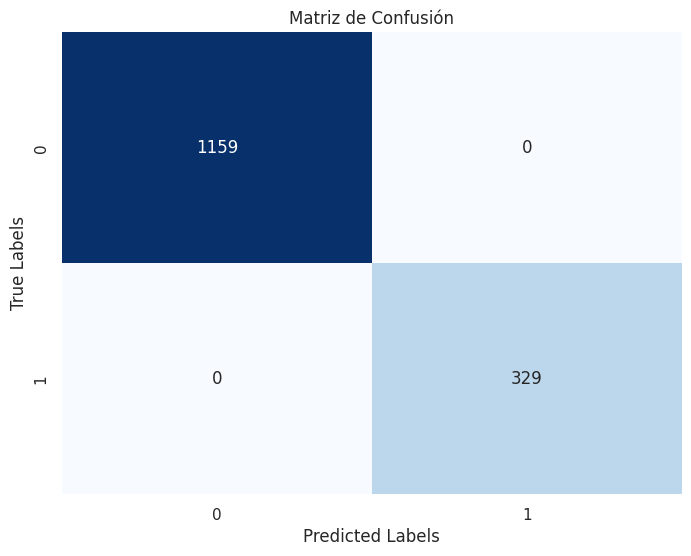

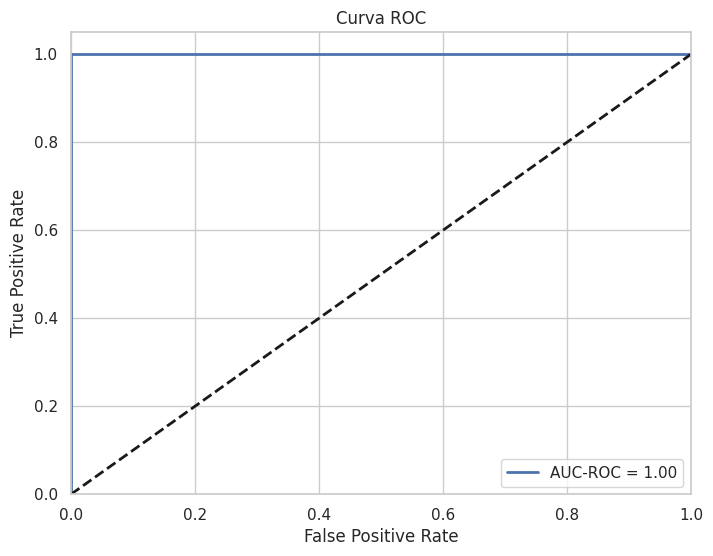

Resultados de la evaluación:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
AUC-ROC: 0.9822523852794185


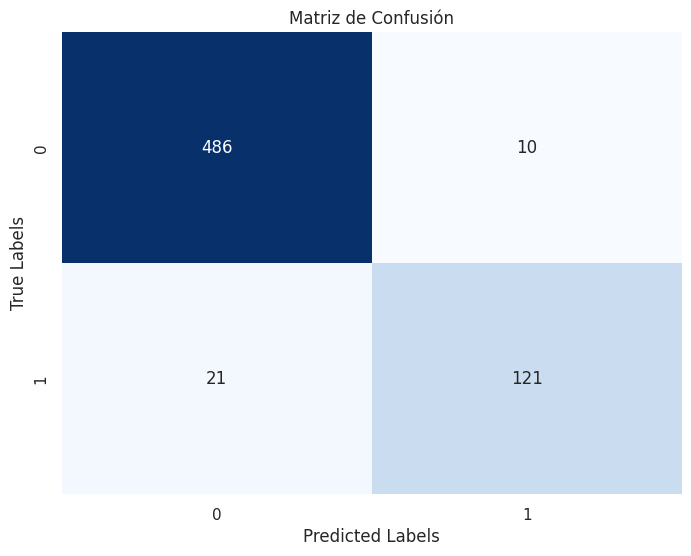

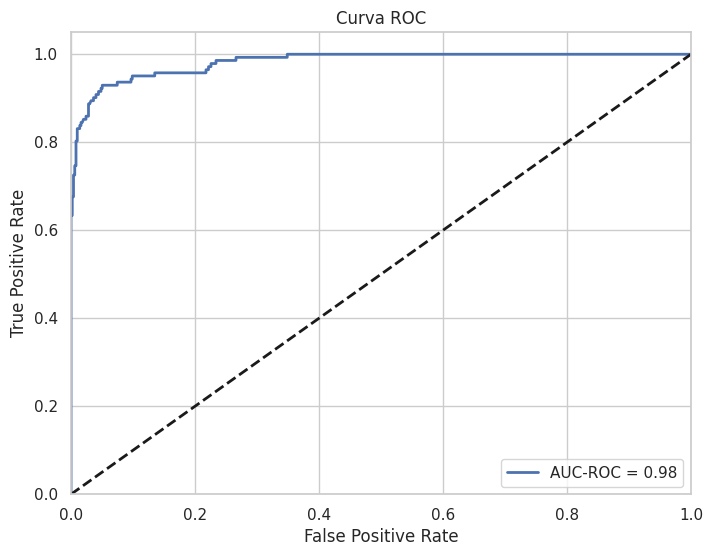

In [ ]:
#Trabajaremos con el modelo de XGboost como ejemplo y porque andubo muy bien:

#recordemos como habia andado:

grid_search_xgboost.fit(X_train, y_train)
best_score = grid_search_xgboost.best_score_

print("Mejores hiperparámetros encontrados:")
print(grid_search_xgboost.best_params_)
print(f"Puntaje del conjunto de hiperparámetros seleccionados: {best_score:.4f}")
eval_model(grid_search_xgboost, X_train, y_train)
resultado_unbalanced = eval_model(grid_search_xgboost, X_test, y_test)

Mejores hiperparámetros encontrados:
{'preprocessor__num': MinMaxScaler()}
Puntaje del conjunto de hiperparámetros seleccionados: 0.8600
Resultados de la evaluación:
Accuracy: 0.83
Precision: 0.87
Recall: 0.83
F1 Score: 0.84
AUC-ROC: 0.942625511131304


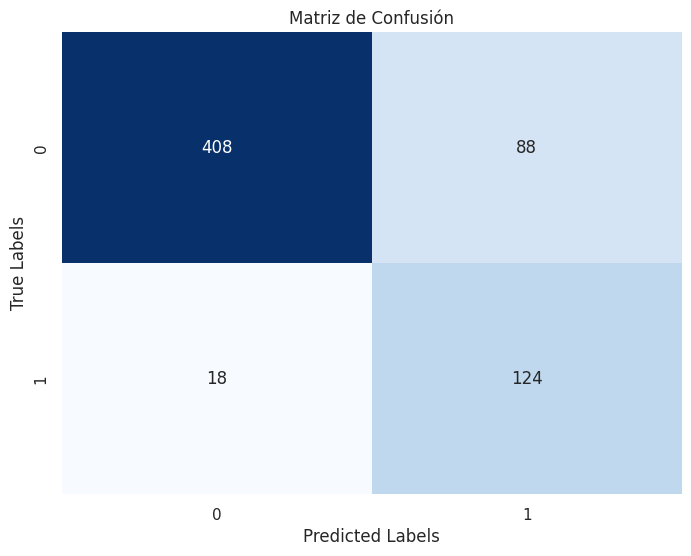

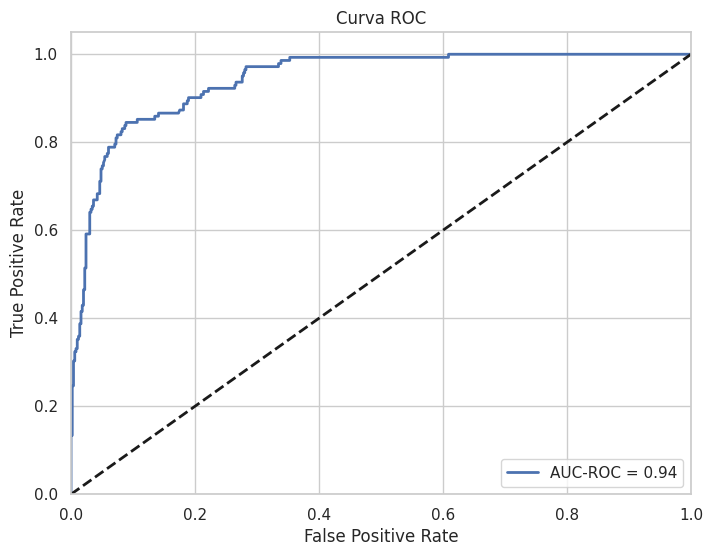

In [ ]:
# Ahora balanceado
grid_search_xgboost_over = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search_xgboost_over.fit(X_train_oversampled, y_train_oversampled)
best_score_over = grid_search_xgboost_over.best_score_


print("Mejores hiperparámetros encontrados:")
print(grid_search_xgboost_over.best_params_)
print(f"Puntaje del conjunto de hiperparámetros seleccionados: {best_score:.4f}")
resultado_over = eval_model(grid_search_xgboost_over, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:236: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  valid_params[key].set_params(**sub_params)


Mejores hiperparámetros encontrados:
{'classifier__base_estimator__max_depth': 4, 'classifier__n_estimators': 82, 'preprocessor__num': MinMaxScaler(), 'selector__k': 15}
Puntaje del conjunto de hiperparámetros seleccionados: 0.8600
Resultados de la evaluación:
Accuracy: 0.9
Precision: 0.91
Recall: 0.9
F1 Score: 0.9
AUC-ROC: 0.9603163334847795


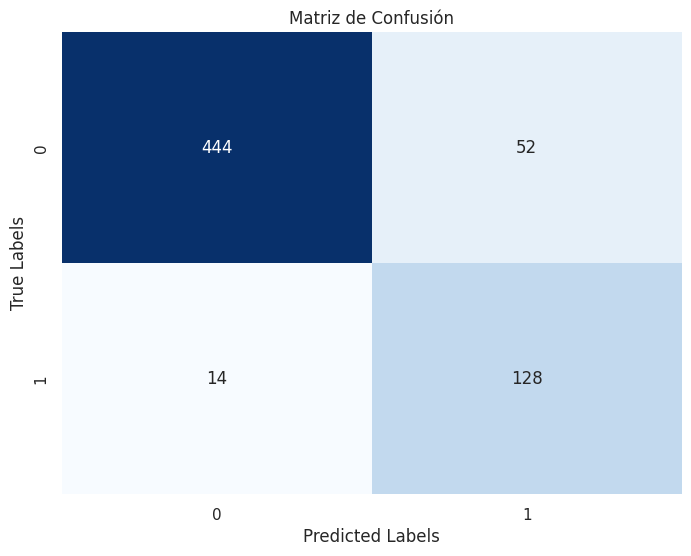

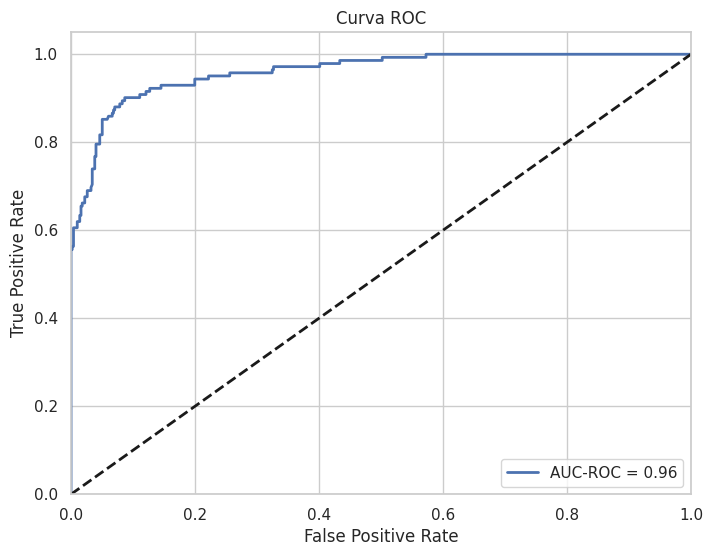

In [ ]:
grid_search_xgboost_sub = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search_xgboost_sub.fit(X_train_subsampled, y_train_subsampled)
best_score_sub = grid_search_xgboost_sub.best_score_

print("Mejores hiperparámetros encontrados:")
print(grid_search_xgboost_sub.best_params_)
print(f"Puntaje del conjunto de hiperparámetros seleccionados: {best_score:.4f}")

resultado_sub = eval_model(grid_search_xgboost_sub, X_test, y_test)

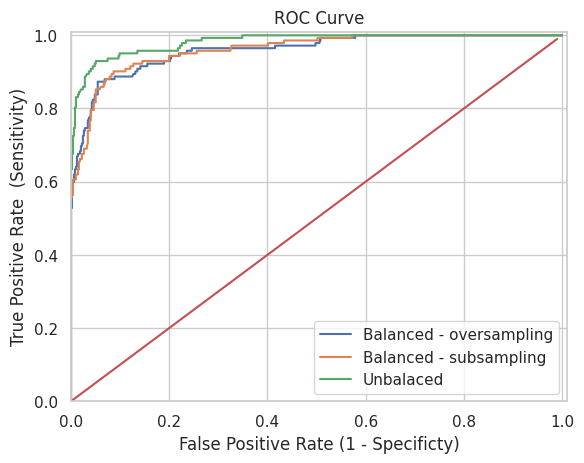

In [ ]:
# Graficamos todo en una misma curva de ROC para poder comparar

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('False Positive Rate (1 - Specificty)')
plt.ylabel('True Positive Rate  (Sensitivity)')
plt.title('ROC Curve')
plt.plot(resultado_over[1],resultado_over[2], label='Balanced - oversampling')
plt.plot(resultado_sub[1],resultado_sub[2], label='Balanced - subsampling')
plt.plot(resultado_unbalanced[1],resultado_unbalanced[2], label='Unbalaced')
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()

El mododelo de XGboost con el dataset balanceado performa practicamente igual que con el dataset desbalanceado. Esto puede deberse a que el grado de desbalanceo no era muy extremo o que estamos observando un efecto techo del modelo (con performance cercanas al 96% es dificil obtener un desempeño mucho mejor)

## ¿Que tal si lo camparamos contra un modelo más sensillo como los del TP3?

Mejores hiperparámetros encontrados:
{'preprocessor__num': MinMaxScaler()}
Puntaje del conjunto de hiperparámetros seleccionados: 0.6716
Resultados de la evaluación:
Accuracy: 0.91
Precision: 0.9
Recall: 0.91
F1 Score: 0.91
AUC-ROC: 0.9428384825079509


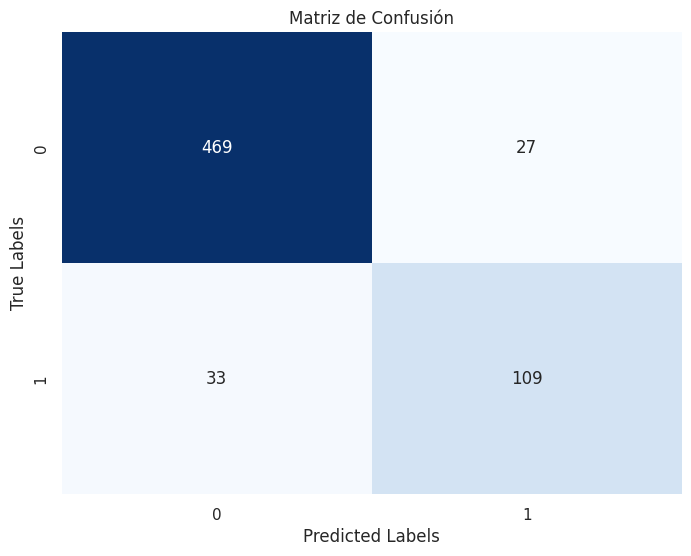

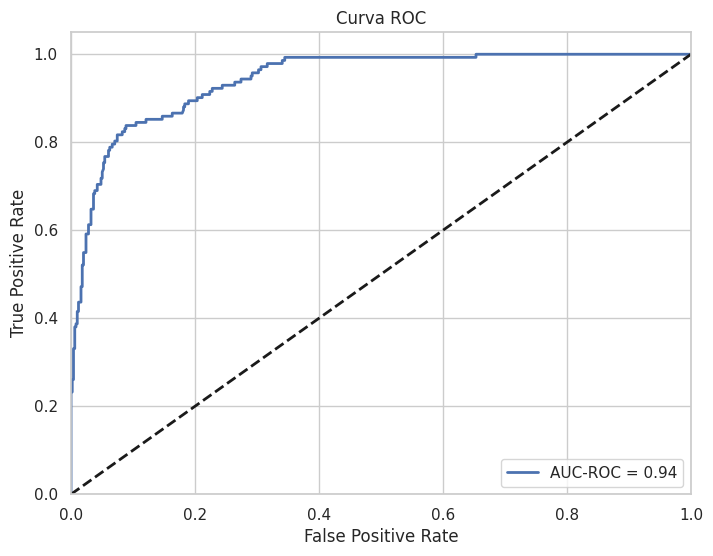

In [ ]:
from sklearn.linear_model import LogisticRegression


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector',SelectKBest(f_classif)),
    ('classifier', LogisticRegression())
])

#  n_neighbors = best_k, metric = 'manhattan'

# dejo los mejores hyper parametros encontrados
param_grid = {
    'preprocessor__num': [MinMaxScaler()],  # [StandardScaler(), MinMaxScaler(), None],

}

grid_search_log = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)

grid_search_log.fit(X_train, y_train)
best_score_log = grid_search_log.best_score_

print("Mejores hiperparámetros encontrados:")
print(grid_search_log.best_params_)
print(f"Puntaje del conjunto de hiperparámetros seleccionados: {best_score_log:.4f}")
resultado_log = eval_model(grid_search_log, X_test, y_test)

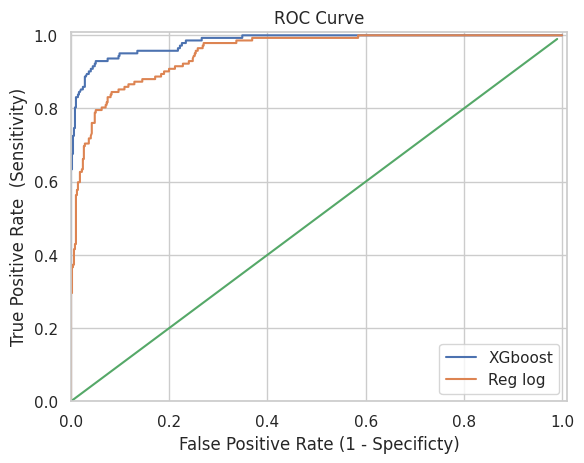

In [ ]:
# Graficamos todo en una misma curva de ROC para poder comparar

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('False Positive Rate (1 - Specificty)')
plt.ylabel('True Positive Rate  (Sensitivity)')
plt.title('ROC Curve')
plt.plot(resultado_unbalanced[1],resultado_unbalanced[2], label='XGboost')
plt.plot(resultado_log[1],resultado_log[2], label='Reg log')
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend()
plt.show()

Si bien la performance con un algoritmo más sencillo como es una regresión logaritmica es igualmente muy bueno, es considerabemente inferior al de XGboost, por lo que consideramos que el aumento en complegidad y en recursos compuitacionales vale la pena en post de consguir un mejor desempeño.

## **Comparación Métricas**

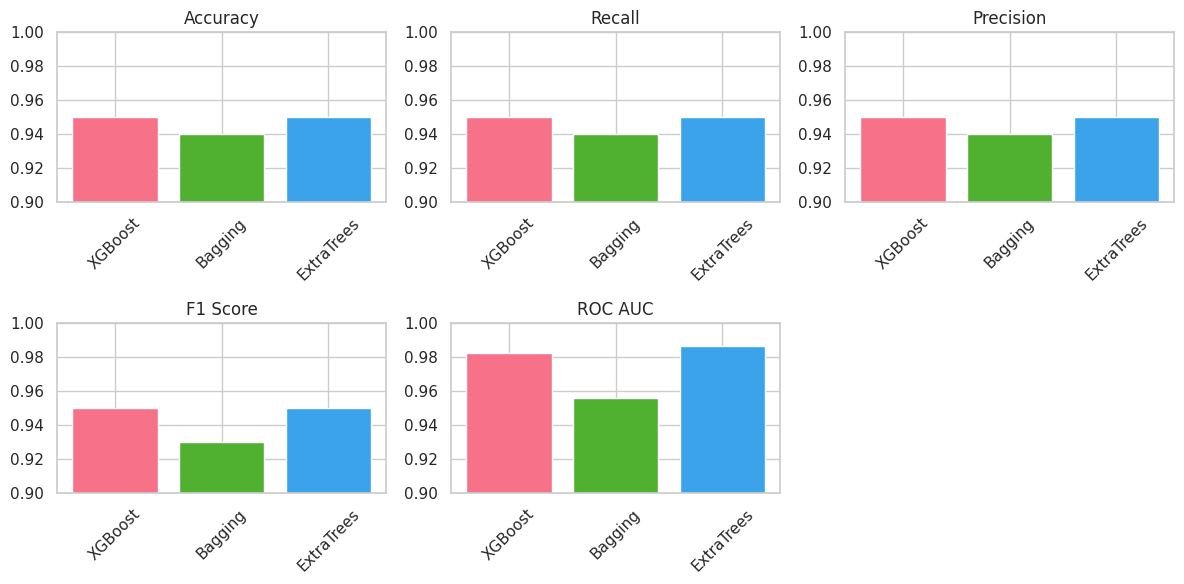

In [ ]:
accuracy_list = accuracy_list[: 3]
precision_list = precision_list[: 3]
recall_list = recall_list[: 3]
f1_list = f1_list[: 3]
auc_roc_list = auc_roc_list[: 3]
modelos = ('XGBoost', 'Bagging', 'ExtraTrees')

metricas_nombres = ["Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC"]
metricas_valores = [accuracy_list, recall_list, precision_list, f1_list, auc_roc_list]

colores_modelos = sns.color_palette("husl", len(modelos))

plt.figure(figsize=(12, 6))

for i in range(len(metricas_nombres)):
    plt.subplot(2, 3, i + 1)
    for j, modelo in enumerate(modelos):
        valores_metrica = metricas_valores[i][j]
        plt.bar(modelo, valores_metrica, color=colores_modelos[j])
    plt.title(f"{metricas_nombres[i]}")
    plt.ylim(0.9, 1)
    plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


## **Pickle**

Guardamos los modelos utilizando la librería Pickle, aunque el que nos interesa es el modelo de XGBoost.



In [ ]:
xgboost_pkl = pickle.dump(grid_search_xgboost, open('grid_search_xgboost.pkl', 'wb'))

bagging_pkl = pickle.dump(grid_search_bagging, open('grid_search_bagging.pkl', 'wb'))

extratrees_pkl = pickle.dump(et, open('et.pkl', 'wb'))

## **Conclusiones**

Luego de analizar detenidamente los resultados obtenidos al aplicar diferentes modelos predictivos al conjunto de datos de Cardiotocograms (CTGs), hemos llegado a la conclusión de que XGBoost es la elección más adecuada para resolver este desafío de clasificación de estados fetales. Aquí están las razones clave detrás de mi elección personal:

**Rendimiento**: es el modelo que mejor rendimiento tuvo:
- Precisión: 0.96
- Recall: 0.96
- F1 Score: 0.96
- AUC-ROC: 0.9844

**Interpretabilidad**: Si bien no es el modelo más facil de interpretar, es más interpretable que es resto de los modelos utilizados.

**Eficiencia**: XGBoost es excelente en terminos de eficiencia de recursos computacionales, lo cual facilita la implementaciòn y entrenamiento de conjuntos más grandes de ser necesarios.